# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
torch.cuda.is_available()

True

# Preprocessing

In [3]:
IMAGE_PATH = 'fullset\\data\\train_features\\'
MASK_PATH = 'fullset\\data\\train_labels\\'

In [4]:
def create_df():
    fnames = []
    for x in os.walk(IMAGE_PATH):
        fnames.append(x[0].split('\\')[3])
    
    return pd.DataFrame({'id': fnames[1:]}, index = np.arange(0, len(fnames)-1))

df = create_df()
print('Total Images: ', len(df))

Total Images:  11748


In [5]:
#split data
X_train, X_val = train_test_split(df['id'].values, test_size=(20/80), random_state=21)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))

Train Size   :  8811
Val Size     :  2937


Image Size (512, 512)
Mask Size (512, 512)


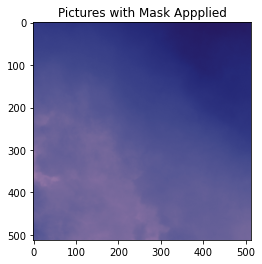

In [6]:
img1 = Image.open(IMAGE_PATH + df['id'][40] + '\\B02.tif')
img2 = Image.open(IMAGE_PATH + df['id'][40] + '\\B03.tif')
img3 = Image.open(IMAGE_PATH + df['id'][40] + '\\B04.tif')
img4 = Image.open(IMAGE_PATH + df['id'][40] + '\\B08.tif')
mask = Image.open(MASK_PATH + df['id'][40] + '.tif')
print('Image Size', np.asarray(img1).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img1, alpha=1, cmap ='Blues')
#plt.imshow(img2, alpha=.5, cmap ='Greens')
#plt.imshow(img3, alpha=.333, cmap ='Reds')
plt.imshow(mask, alpha=.5) #Cloud Masking
plt.title('Pictures with Mask Appplied')
plt.show()

# Finding Mean and Standard Deviation

In [7]:
'''
####### COMPUTE MEAN / STD

class MetaDataset(Dataset):
    
    def __init__(self, img_path, X, transform=None,):
        self.img_path = img_path
        self.X = X
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img1 = cv2.imread(self.img_path + self.X[idx] + '\\B02.tif', cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(self.img_path + self.X[idx] + '\\B03.tif', cv2.IMREAD_GRAYSCALE)
        img3 = cv2.imread(self.img_path + self.X[idx] + '\\B04.tif', cv2.IMREAD_GRAYSCALE)
        img4 = cv2.imread(self.img_path + self.X[idx] + '\\B08.tif', cv2.IMREAD_GRAYSCALE)
        
        img1 = Image.fromarray(img1)
        img2 = Image.fromarray(img2)
        img3 = Image.fromarray(img3)
        img4 = Image.fromarray(img4)
        
        #t = T.Compose([T.ToTensor(), T.Normalize(0, 1)])
        t = T.Compose([T.ToTensor(), T.Normalize(0, 1)])
        img1 = t(img1)
        img2 = t(img2)
        img3 = t(img3)
        img4 = t(img4)
   
        return torch.cat([img1, img2, img3, img4])

# Transforms
augs = A.Compose([A.Resize(height= 512, width = 512), A.Normalize(mean = (0, 0, 0, 0), std  = (1, 1, 1, 1))
                  ,ToTensorV2()])

# dataset
full_set = df['id'].values
image_dataset = MetaDataset(img_path = IMAGE_PATH, X = full_set, transform = augs)

# data loader
batch_size = 256
num_workers = 0
image_loader = DataLoader(image_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers, pin_memory = True)
    
# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])
    
####### FINAL CALCULATIONS

# pixel count
count = len(df) * 512 * 512

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))
'''

"\n####### COMPUTE MEAN / STD\n\nclass MetaDataset(Dataset):\n    \n    def __init__(self, img_path, X, transform=None,):\n        self.img_path = img_path\n        self.X = X\n        self.transform = transform\n        \n    def __len__(self):\n        return len(self.X)\n    \n    def __getitem__(self, idx):\n        img1 = cv2.imread(self.img_path + self.X[idx] + '\\B02.tif', cv2.IMREAD_GRAYSCALE)\n        img2 = cv2.imread(self.img_path + self.X[idx] + '\\B03.tif', cv2.IMREAD_GRAYSCALE)\n        img3 = cv2.imread(self.img_path + self.X[idx] + '\\B04.tif', cv2.IMREAD_GRAYSCALE)\n        img4 = cv2.imread(self.img_path + self.X[idx] + '\\B08.tif', cv2.IMREAD_GRAYSCALE)\n        \n        img1 = Image.fromarray(img1)\n        img2 = Image.fromarray(img2)\n        img3 = Image.fromarray(img3)\n        img4 = Image.fromarray(img4)\n        \n        #t = T.Compose([T.ToTensor(), T.Normalize(0, 1)])\n        t = T.Compose([T.ToTensor(), T.Normalize(0, 1)])\n        img1 = t(img1)\n     

# Dataset

In [8]:
class CloudDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img1 = cv2.imread(self.img_path + self.X[idx] + '\\B02.tif', cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(self.img_path + self.X[idx] + '\\B03.tif', cv2.IMREAD_GRAYSCALE)
        img3 = cv2.imread(self.img_path + self.X[idx] + '\\B04.tif', cv2.IMREAD_GRAYSCALE)
        img4 = cv2.imread(self.img_path + self.X[idx] + '\\B08.tif', cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.tif', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug1 = self.transform(image=img1, mask=mask)
            img1 = Image.fromarray(aug1['image'])
            aug2 = self.transform(image=img2, mask=mask)
            img2 = Image.fromarray(aug2['image'])
            aug3 = self.transform(image=img3, mask=mask)
            img3 = Image.fromarray(aug3['image'])
            aug4 = self.transform(image=img4, mask=mask)
            img4 = Image.fromarray(aug4['image'])
            mask = aug1['mask']
        
        if self.transform is None:
            img1 = Image.fromarray(img1)
            img2 = Image.fromarray(img2)
            img3 = Image.fromarray(img3)
            img4 = Image.fromarray(img4)
        
        t1 = T.Compose([T.ToTensor(), T.Normalize(self.mean[0], self.std[0])])
        t2 = T.Compose([T.ToTensor(), T.Normalize(self.mean[1], self.std[1])])
        t3 = T.Compose([T.ToTensor(), T.Normalize(self.mean[2], self.std[2])])
        t4 = T.Compose([T.ToTensor(), T.Normalize(self.mean[3], self.std[3])])
        
        img1 = t1(img1)
        img2 = t2(img2)
        img3 = t3(img3)
        img4 = t4(img4)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img1, mask = self.tiles(img1, mask)
            img2, mask = self.tiles(img2, mask)
            img3, mask = self.tiles(img3, mask)
            img4, mask = self.tiles(img4, mask)
            
            
        return torch.cat([img1, img2, img3, img4]), mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [9]:
## Imagenet values:
#mean=[0.485, 0.456, 0.406]
#std=[0.229, 0.224, 0.225]

## Small proof of concept values:
#mean = [0.0711, 0.0678, 0.0633, 0.0670]
#std = [0.0642, 0.0582, 0.0548, 0.0469]

# Full dataset values:
mean = [0.0417, 0.0415, 0.0401, 0.0541]
std = [0.0484, 0.0444, 0.0428, 0.0371]

t_train = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = CloudDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = CloudDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

# Model

In [10]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16], in_channels=4)

In [11]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), 

# Training

In [12]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [13]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                
                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculation mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss failed to decrease ({not_improve} of 7)')
                if not_improve == 7:
                    print('Loss failed to decrease for the 7th time. Training stopped.')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [15]:
max_lr = 1e-2
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.429 
Epoch:1/20.. Train Loss: 0.536.. Val Loss: 0.429.. Train mIoU:0.559.. Val mIoU: 0.651.. Train Acc:0.728.. Val Acc:0.800.. Time: 13.10m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.429 >> 0.402 
Epoch:2/20.. Train Loss: 0.425.. Val Loss: 0.402.. Train mIoU:0.664.. Val mIoU: 0.677.. Train Acc:0.806.. Val Acc:0.813.. Time: 9.33m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.402 >> 0.331 
Epoch:3/20.. Train Loss: 0.385.. Val Loss: 0.331.. Train mIoU:0.705.. Val mIoU: 0.755.. Train Acc:0.834.. Val Acc:0.870.. Time: 9.27m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/20.. Train Loss: 0.375.. Val Loss: 0.378.. Train mIoU:0.711.. Val mIoU: 0.688.. Train Acc:0.840.. Val Acc:0.836.. Time: 9.33m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.378 >> 0.367 
saving model...
Epoch:5/20.. Train Loss: 0.363.. Val Loss: 0.367.. Train mIoU:0.724.. Val mIoU: 0.720.. Train Acc:0.848.. Val Acc:0.847.. Time: 9.31m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.367 >> 0.330 
Epoch:6/20.. Train Loss: 0.351.. Val Loss: 0.330.. Train mIoU:0.734.. Val mIoU: 0.758.. Train Acc:0.855.. Val Acc:0.871.. Time: 9.41m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.330 >> 0.303 
Epoch:7/20.. Train Loss: 0.338.. Val Loss: 0.303.. Train mIoU:0.741.. Val mIoU: 0.783.. Train Acc:0.861.. Val Acc:0.888.. Time: 9.45m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.303 >> 0.296 
Epoch:8/20.. Train Loss: 0.333.. Val Loss: 0.296.. Train mIoU:0.746.. Val mIoU: 0.790.. Train Acc:0.864.. Val Acc:0.893.. Time: 9.48m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:9/20.. Train Loss: 0.323.. Val Loss: 0.306.. Train mIoU:0.755.. Val mIoU: 0.765.. Train Acc:0.870.. Val Acc:0.875.. Time: 9.50m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.306 >> 0.288 
Epoch:10/20.. Train Loss: 0.316.. Val Loss: 0.288.. Train mIoU:0.760.. Val mIoU: 0.795.. Train Acc:0.873.. Val Acc:0.894.. Time: 9.37m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:11/20.. Train Loss: 0.311.. Val Loss: 0.292.. Train mIoU:0.766.. Val mIoU: 0.780.. Train Acc:0.877.. Val Acc:0.887.. Time: 9.36m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.292 >> 0.288 
saving model...
Epoch:12/20.. Train Loss: 0.306.. Val Loss: 0.288.. Train mIoU:0.769.. Val mIoU: 0.788.. Train Acc:0.879.. Val Acc:0.894.. Time: 9.38m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.288 >> 0.273 
Epoch:13/20.. Train Loss: 0.297.. Val Loss: 0.273.. Train mIoU:0.776.. Val mIoU: 0.803.. Train Acc:0.883.. Val Acc:0.901.. Time: 9.39m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:14/20.. Train Loss: 0.289.. Val Loss: 0.275.. Train mIoU:0.781.. Val mIoU: 0.800.. Train Acc:0.887.. Val Acc:0.900.. Time: 9.40m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:15/20.. Train Loss: 0.283.. Val Loss: 0.279.. Train mIoU:0.787.. Val mIoU: 0.790.. Train Acc:0.890.. Val Acc:0.895.. Time: 9.36m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.279 >> 0.261 
Epoch:16/20.. Train Loss: 0.279.. Val Loss: 0.261.. Train mIoU:0.791.. Val mIoU: 0.816.. Train Acc:0.893.. Val Acc:0.907.. Time: 9.37m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.261 >> 0.260 
Epoch:17/20.. Train Loss: 0.272.. Val Loss: 0.260.. Train mIoU:0.796.. Val mIoU: 0.812.. Train Acc:0.896.. Val Acc:0.906.. Time: 9.36m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:18/20.. Train Loss: 0.270.. Val Loss: 0.262.. Train mIoU:0.797.. Val mIoU: 0.817.. Train Acc:0.896.. Val Acc:0.908.. Time: 9.36m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.262 >> 0.258 
Epoch:19/20.. Train Loss: 0.266.. Val Loss: 0.258.. Train mIoU:0.799.. Val mIoU: 0.813.. Train Acc:0.898.. Val Acc:0.908.. Time: 9.38m


  0%|          | 0/1102 [00:00<?, ?it/s]

  0%|          | 0/368 [00:00<?, ?it/s]

Loss Decreasing.. 0.258 >> 0.255 
saving model...
Epoch:20/20.. Train Loss: 0.264.. Val Loss: 0.255.. Train mIoU:0.802.. Val mIoU: 0.820.. Train Acc:0.899.. Val Acc:0.909.. Time: 9.37m
Total time: 191.28 m


In [16]:
torch.save(model, 'Unet-Clouds.pt')

In [17]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

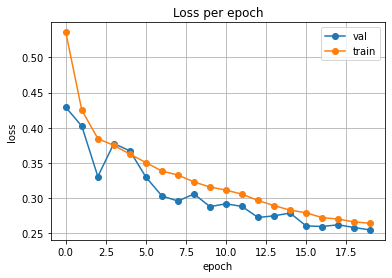

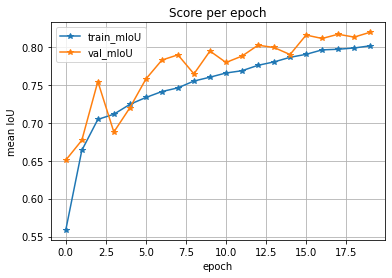

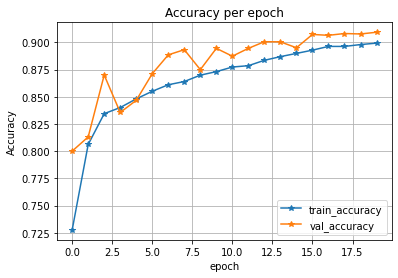

In [18]:
plot_loss(history)
plot_score(history)
plot_acc(history)